
# <span style="font-variant: small-caps"> Big Data </span>

## Assignment 2
zuzan

---
**Task 1** Given a 2D matrix (or list of lists), count how many numbers are present in a given range.

**Task 2** Download as many books as possible from the Gutenberg project and:
* count the words in all books,
* compute a histogram of the words.

**Task 3** Compute exact digits of π using the Bailey-Borwein-Plouffe algorithm.

**Task 4** Calculate the product of two random matrices.

All programs should follow the MapReduce model. Use multiprocessing module in Python to implement its simple single-server version. Run the programs in both the serialized and parallel manner and compare the execution times.

---

### Task 1

Given a 2D matrix (or list of lists), count how many numbers are present in a given range.

In [1]:
import numpy as np
from functools import reduce

In [2]:
def count_in_range(matrix, lower, upper):
    """Counts numbers in `matrix` which lie in the [low, high] interval."""
    return ((matrix >= lower) & (matrix <= upper)).sum()

In [3]:
def reducer(x, y):
    return x + y

def count_in_range_mapreduce(matrix, lower, upper):
    mapper = lambda value: int((value >= lower) & (value <= upper))
    mapped = map(mapper, matrix.flatten())         # flatten() works very fast, it does not really affect the execution time
    reduced = reduce(reducer, mapped)
    return reduced

In [4]:
mx = np.random.randint(0,99,(10000,10000))

In [6]:
%%time
count_in_range(mx, 1, 7)

Wall time: 392 ms


7070433

In [7]:
%%time
count_in_range_mapreduce(mx, 1, 7)

Wall time: 2min 25s


7070433

In [2]:
from multiprocessing import Pool
from multiprocessing import cpu_count

In [37]:
lower = 1
upper = 7

def mapper(x):
    return int((x[0] >= x[1]) & (x[0] <= x[2]))

def reducer(x, y):
    return x + y

def chunks_mapper(chunk):
    mapped_chunk = map(mapper, chunk) 
    return reduce(reducer, mapped_chunk)

# in order to use these functions with multiprocessing in Windows, I saved them in file a2_func.py which then I import
# and use especially imported chunks_mapper

In [13]:
%%time
# let's check the time not using multiprocessing

lower = 1
upper = 7
all_cells = mx.flatten()
zipped = zip(all_cells, [lower]*len(all_cells), [upper]*len(all_cells))
reduce(reducer, map(chunks_mapper, np.array_split(list(zipped),2)))

Wall time: 4min 14s


In [11]:
import a2_func
import imp
imp.reload(a2_func)

<module 'a2_func' from 'C:\\Users\\zuzan\\Documents\\_big_data\\a2_func.py'>

In [34]:
def count_in_range_mapreduce_multipr(matrix, lower, upper):
    if __name__ ==  '__main__': 
        pool = Pool(cpu_count())
        all_cells = matrix.flatten()
        zipped = zip(all_cells, [lower]*len(all_cells), [upper]*len(all_cells))
        data_chunks = np.array_split(list(zipped), 8)
        mapped = pool.map(a2_func.chunks_mapper, data_chunks)
        reduced = reduce(reducer, mapped)
        return reduced

In [10]:
%%time
count_in_range_mapreduce_multipr(mx, 1, 7)

Wall time: 3min 1s


7074074

In [35]:
# to answer the question in the form to fill

ij_matrix = np.zeros((2000,2000))
for i in range(2000):
    for j in range(2000):
        ij_matrix[i,j] = i-j

In [39]:
%%time
# parallel computing
count_in_range_mapreduce_multipr(ij_matrix, 3, 6)

Wall time: 11.5 s


7982

In [40]:
%%time
# serialized 

lower = 3
upper = 6
all_cells = ij_matrix.flatten()
zipped = zip(all_cells, [lower]*len(all_cells), [upper]*len(all_cells))
print(reduce(reducer, map(chunks_mapper, np.array_split(list(zipped),2))))

7982
Wall time: 11.9 s


### Task 2

Download as many books as possible from the Gutenberg project and:
 * count the words in all books,
 * compute a histogram of the words

In [41]:
import glob

In [85]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

def one_book_word_count(filename):
    with open(filename, "r", encoding="ASCII") as file:
        text = file.read()
    start_idx = text.find('***') + text[text.find('***') + 3 :].find('***') + 6
    end_idx = text.find('*** END')
    text = text[start_idx:end_idx].replace('\n',' ').replace('.',' ').replace(',',' ').replace(':',' ').replace(';',' ').replace('?',
            ' ').replace('!',' ').replace('"',' ').replace("—"," ").replace('_',' ').replace('[',' ').replace(']',' ').replace('(',
            ' ').replace(')',' ').replace('0',' ').replace('1',' ').replace('2',' ').replace('3',' ').replace('4',' ').replace('5',
            ' ').replace('6',' ').replace('7',' ').replace('8',' ').replace('9',' ').lower()
    text_tokenized = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    text_stem = [lemmatizer.lemmatize(item) for item in text_tokenized if ((len(lemmatizer.lemmatize(item)) > 1) & (item not in stop_words))]
    dict_of_words = dict(Counter(t))
    
    return dict_of_words

In [ ]:
def add_word_dicts(dict1, dict2):
    for k, v in dict2.items():
        if k in dict1.keys():
            dict1[k] = dict1[k] + v
        else:
            dict1[k] = v
    return dict1

# both functions are in a2_func file anyway

In [42]:
%%time

if __name__ ==  '__main__': 
    filenames = glob.glob('./gutenberg/*.txt')
    pool = Pool(1)
    mapped = pool.map(a2_func.one_book_word_count, filenames[:600])
    reduced = reduce(a2_func.add_word_dicts, mapped)

Wall time: 10min 39s


In [43]:
%%time

if __name__ ==  '__main__':
    filenames = glob.glob('./gutenberg/*.txt')
    pool = Pool(None)
    mapped = pool.map(a2_func.one_book_word_count, filenames[:600])
    reduced = reduce(a2_func.add_word_dicts, mapped)

Wall time: 4min 46s


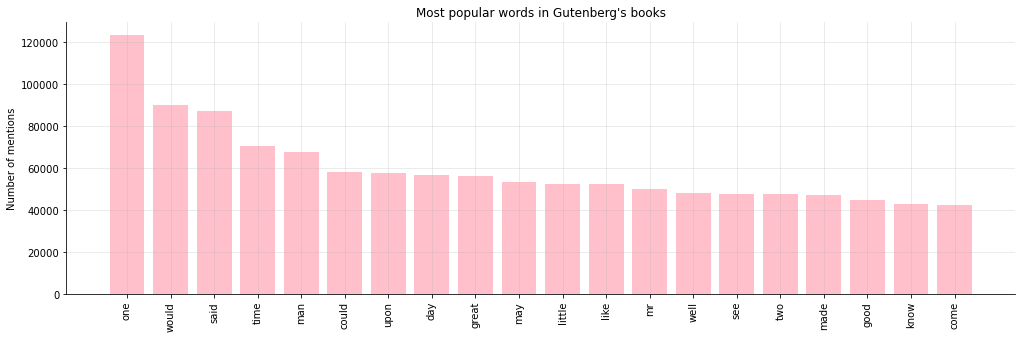

In [45]:
import matplotlib.pyplot as plt

list_of_words = sorted([[word, number] for word, number in reduced.items()], key = lambda x: x[1], reverse=True)
limit = 20
words = [x[0] for x in list_of_words[:limit]]
numbers = [x[1] for x in list_of_words[:limit]]

fig, ax = plt.subplots(1,1, figsize=(17,5))
ax.bar(range(limit), numbers, align='center', color='pink')
ax.set_title("Most popular words in Gutenberg's books")
ax.set_xticks(range(limit))
ax.set_xticklabels(words, rotation='vertical')
ax.set_ylabel('Number of mentions')
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
plt.show()

### Task 4

Calculate the product of two random matrices

In [64]:
A = np.random.randint(1,29,(400,240))

In [65]:
B = np.random.randint(1,29,(240,250))

In [66]:
%%time

if __name__ ==  '__main__':
    from itertools import chain
    pool = Pool(1)
    
    # A is i x j matrix, but I will put j's as a first argument
    m_A = zip([*range(A.shape[1])] * A.shape[0], chain(*zip(*[range(A.shape[0])] * A.shape[1])), A.flatten(), ['A']*A.shape[0]*A.shape[1])
    # B is j x k, so the first argument fits the same function as for A
    m_B = zip(chain(*zip(*[range(B.shape[0])] * B.shape[1])), [*range(B.shape[1])] * B.shape[0], B.flatten(), ['B']*B.shape[0]*B.shape[1])

    matrices = chain(*zip(m_A), *zip(m_B))
    
    mapped = pool.map(a2_func.make_pairs, matrices)

    all_js = dict()
    for one_cell in mapped:
        j, rest = one_cell
        if j in all_js.keys():
            all_js[j].append(rest)
        else:
            all_js[j] = [rest]
    
    result = reduce(a2_func.sum_up, list(pool.map(a2_func.first_multiply, list(all_js.values()))))

Wall time: 4min 5s


In [69]:
%%time

if __name__ ==  '__main__':
    from itertools import chain
    pool = Pool(None)
    
    # A is i x j matrix, but I will put j's as a first argument
    m_A = zip([*range(A.shape[1])] * A.shape[0], chain(*zip(*[range(A.shape[0])] * A.shape[1])), A.flatten(), ['A']*A.shape[0]*A.shape[1])
    # B is j x k, so the first argument fits the same function as for A
    m_B = zip(chain(*zip(*[range(B.shape[0])] * B.shape[1])), [*range(B.shape[1])] * B.shape[0], B.flatten(), ['B']*B.shape[0]*B.shape[1])

    matrices = chain(*zip(m_A), *zip(m_B))
    
    mapped = pool.map(a2_func.make_pairs, matrices)

    all_js = dict()
    for one_cell in mapped:
        j, rest = one_cell
        if j in all_js.keys():
            all_js[j].append(rest)
        else:
            all_js[j] = [rest]
    
    result = reduce(a2_func.sum_up, list(pool.map(a2_func.first_multiply, list(all_js.values()))))

Wall time: 3min 34s


In [68]:
%%time
np.dot(A, B)

Wall time: 30 ms


array([[45922, 49368, 48098, ..., 46536, 46405, 48388],
       [45257, 49388, 50560, ..., 47612, 47062, 49496],
       [46835, 51671, 52926, ..., 49512, 50016, 50671],
       ...,
       [48431, 53144, 54949, ..., 52536, 50672, 50844],
       [49108, 52369, 53290, ..., 51772, 49598, 51177],
       [48374, 53100, 52235, ..., 51116, 49145, 50951]])

###  Task 3

Compute exact digits of π using the Bailey-Borwein-Plouffe algorithm.

Inspired by http://pythonfiddle.com/bailey-borwein-plouffe-formula/

In [51]:
imp.reload(a2_func)

<module 'a2_func' from 'C:\\Users\\zuzan\\Documents\\_big_data\\a2_func.py'>

In [60]:
print(a2_func.nth_pi_digit(0))
print(a2_func.nth_pi_digit(9999))

3
c


In [61]:
%%time

if __name__ == '__main__':
    n = 10000
    pool = Pool(1)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced[:10], ' ... ', reduced[-10:])

3.243f6a88  ...  926aab49ec
Wall time: 9min 36s


In [63]:
%%time

if __name__ == '__main__':
    n = 10000
    pool = Pool(None)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced[:10], ' ... ', reduced[-10:])

3.243f6a88  ...  926aab49ec
Wall time: 4min 16s


In [59]:
%%time

if __name__ == '__main__':
    n = 100
    pool = Pool(None)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced)

3.243f6a8885a308d313198a2e03707344a4093822299f31d0082efa98ec4e6c89452821e638d01377be5466cf34e90c6cc0a
Wall time: 3.23 s
